# Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE

### ---- 1 Define the problem ----

As a data scientist, we need to examine the job postings with salaries and predict the salaries for new postings.

In [120]:
#import your libraries
import pandas as pd
import numpy as np
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


#etc

#your info here
__author__ = "Nikhil Gharge"
__email__ = "nikhilgharge93@gmail.com"

## Part 2 - DISCOVER

### ---- 2 Load the data ----

In [121]:
#load the data into a Pandas dataframe
def load_dataset():
    trainData_features_df = pd.read_csv("/Users/nikhilgharge93gmail.com/Desktop/Data Science Dream Job/Instructions_and_Notebook/salaryPredictionPortfolio/Data/train_features.csv")
    trainData_target_df = pd.read_csv("/Users/nikhilgharge93gmail.com/Desktop/Data Science Dream Job/Instructions_and_Notebook/salaryPredictionPortfolio/Data/train_salaries.csv")
    testData_features_df = pd.read_csv("/Users/nikhilgharge93gmail.com/Desktop/Data Science Dream Job/Instructions_and_Notebook/salaryPredictionPortfolio/Data/test_features.csv")
    return trainData_features_df, trainData_target_df, testData_features_df

In [122]:
trainData_features_df, trainData_target_df, testData_features_df = load_dataset()

In [123]:
# This file contains features of different employees
trainData_features_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [124]:
# This file contains the salary of respective employees with their jobId
trainData_target_df.head()

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


In [125]:
# We need to predict the salaries for the employees in this test data.
testData_features_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44


### ---- 3 Clean the data ----

In [126]:
#look for duplicate data, invalid data (e.g. salaries <=0), or corrupt data and remove it
def duplicate_data():
    duplicate_train_features = trainData_features_df.duplicated().sum()
    duplicate_train_target=trainData_target_df.duplicated().sum()
    duplicate_test_features=testData_features_df.duplicated().sum()
    return duplicate_test_features, duplicate_train_features,duplicate_train_target

In [127]:
duplicate_test_features, duplicate_train_features,duplicate_train_target = duplicate_data()

In [128]:
print(duplicate_test_features, duplicate_train_features,duplicate_train_target)

0 0 0


As we can see there are no duplicates present in the above three files.

In [129]:
# Create a final dataset by merging trainData_features_df and trainData_target_df
def merge_Datasets():
    salaryPred_Train_data = pd.merge(trainData_features_df,trainData_target_df,how='inner',on='jobId')
    return salaryPred_Train_data

In [130]:
salaryPred_Train_data = merge_Datasets()

In [131]:
salaryPred_Train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
salary                 1000000 non-null int64
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


In [132]:
salaryPred_Train_data.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


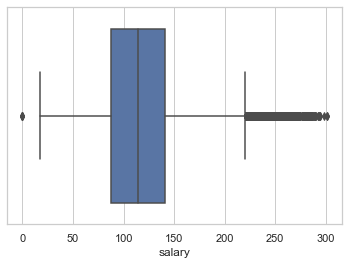

In [133]:
# boxplot for salary columns.
sns.set(style="whitegrid")
ax = sns.boxplot(x=salaryPred_Train_data["salary"])

As it clearly depicts, most of the outliers are in the right most whiskers. 
Finally we will conisder only those values which have salary > 0 in the final dataset

In [134]:
# Boxplot Analysis
info_salaryPredDataset = salaryPred_Train_data.salary.describe()
print(info_salaryPredDataset)
IQR = info_salaryPredDataset['75%'] - info_salaryPredDataset["25%"]
upper = info_salaryPredDataset['75%'] + 1.5 * IQR
lower = info_salaryPredDataset['25%'] - 1.5 * IQR
print("The upper and lower bounds for suspected outliers are {} and {}.".format(upper, lower))

count    1000000.000000
mean         116.061818
std           38.717936
min            0.000000
25%           88.000000
50%          114.000000
75%          141.000000
max          301.000000
Name: salary, dtype: float64
The upper and lower bounds for suspected outliers are 220.5 and 8.5.


In [135]:
# Considering values related to respective upper and lower bounds
salaryPred_Train_data[salaryPred_Train_data['salary'] < lower]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


In [136]:
salaryPred_Train_data.loc[salaryPred_Train_data['salary'] > upper, 'jobType'].value_counts()

CEO               3227
CFO               1496
CTO               1488
VICE_PRESIDENT     603
MANAGER            217
SENIOR              66
JUNIOR              20
Name: jobType, dtype: int64

In [137]:
# remove salary below 0
salaryPred_Train_data = salaryPred_Train_data[salaryPred_Train_data['salary'] > lower]
salaryPred_Train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999995 entries, 0 to 999999
Data columns (total 9 columns):
jobId                  999995 non-null object
companyId              999995 non-null object
jobType                999995 non-null object
degree                 999995 non-null object
major                  999995 non-null object
industry               999995 non-null object
yearsExperience        999995 non-null int64
milesFromMetropolis    999995 non-null int64
salary                 999995 non-null int64
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


### ---- 4 Explore the data (EDA) ----

In [138]:
def build_plot(col):
    avg_Sal = salaryPred_Train_data.groupby(col)["salary"].mean()
    plt.ylabel("Salary")
    avg_Sal.plot()

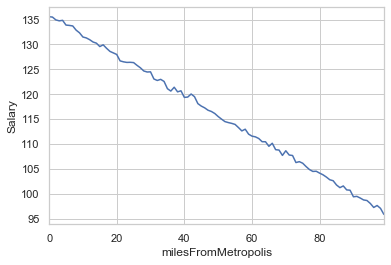

In [139]:
build_plot("milesFromMetropolis")

This shows a negative correlation between salary and milesFromMetropolis. 
As miles tend to increase the salaries get decreased.

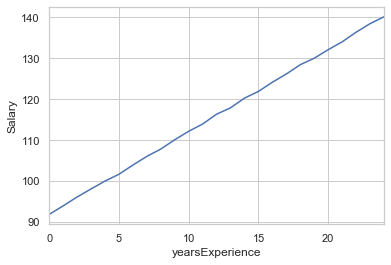

In [140]:
build_plot("yearsExperience")

This graph depicts that as yearsOfExperince increases our salaries increases. 
Basically it depicts an positive correlation between yearsExperience and salary.

In [141]:
def boxen_plot(col):
    f, ax = plt.subplots(figsize= (15,8))
    sns.boxenplot(x=col , y="salary", data = salaryPred_Train_data.sort_values('salary'))
    plt.xticks(rotation=90)

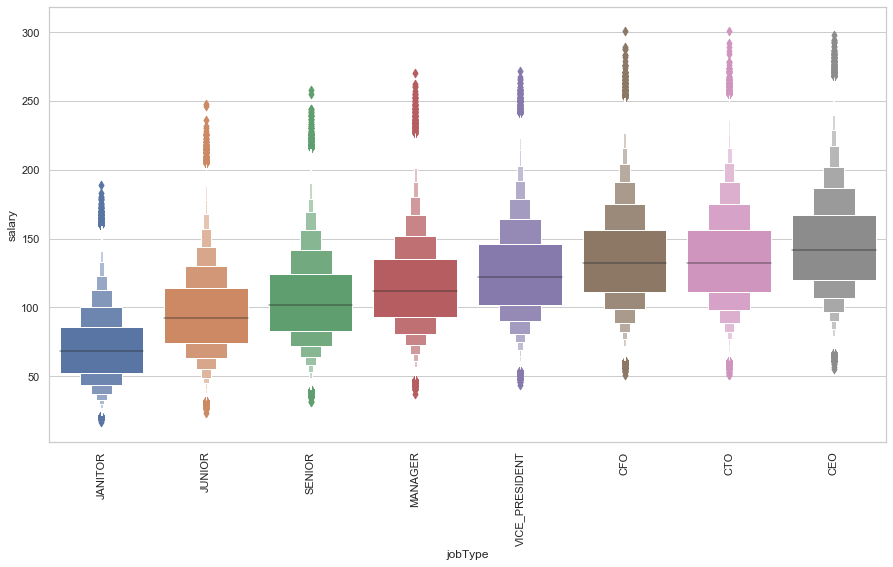

In [142]:
boxen_plot("jobType")

As we can see as position increases salary tends to increase. So there is an positive correlation between salary and jobType.

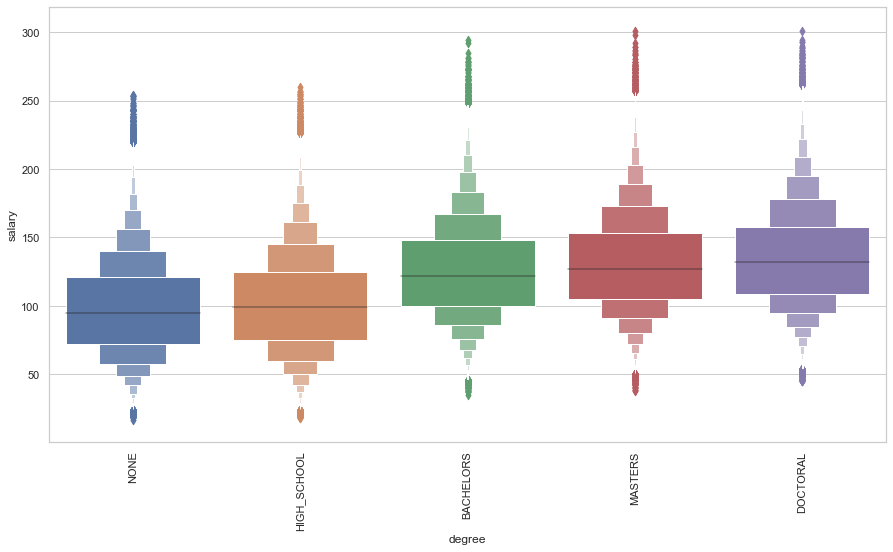

In [143]:
boxen_plot('degree')

As we move up the higher grade, we see a rise in payment of employees. So the target variable salary is positive correlated with degree.

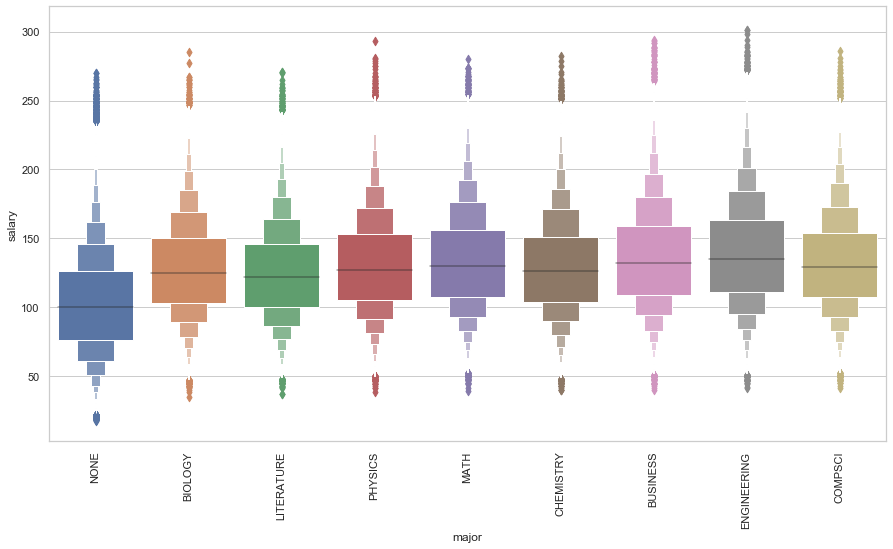

In [144]:
boxen_plot("major")

Above pic clearly depicts that most number of salaries are offerred to engineering and business employees.

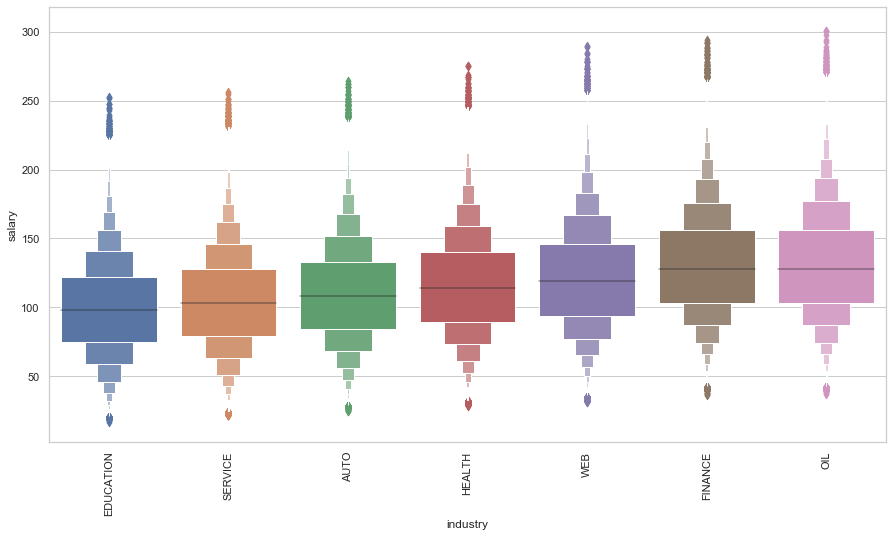

In [145]:
boxen_plot("industry")

As we can see that, oil and finance industry employees have almost the same payment. 

In [146]:
def encode_Label(df, col):
    #encode the categories using average salary for each category to replace label
    cat_dict = {}
    cats = salaryPred_Train_data[col].cat.categories.tolist()
    print(cats)
    for cat in cats:
        cat_dict[cat] = salaryPred_Train_data[salaryPred_Train_data[col] == cat]['salary'].mean()
    print(cat_dict)
    df[col] = df[col].map(cat_dict)   

In [147]:
for col in salaryPred_Train_data.columns:
    if salaryPred_Train_data[col].dtype.name == "category":
        encode_Label(salaryPred_Train_data, col)

In [148]:
salaryPred_Train_data.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [149]:
# Correlation between target variable and feature variable
salaryPred_Train_data.corr()

,yearsExperience,milesFromMetropolis,salary
yearsExperience,1.000000,0.000672,0.375013
milesFromMetropolis,0.000672,1.000000,-0.297686
salary,0.375013,-0.297686,1.000000


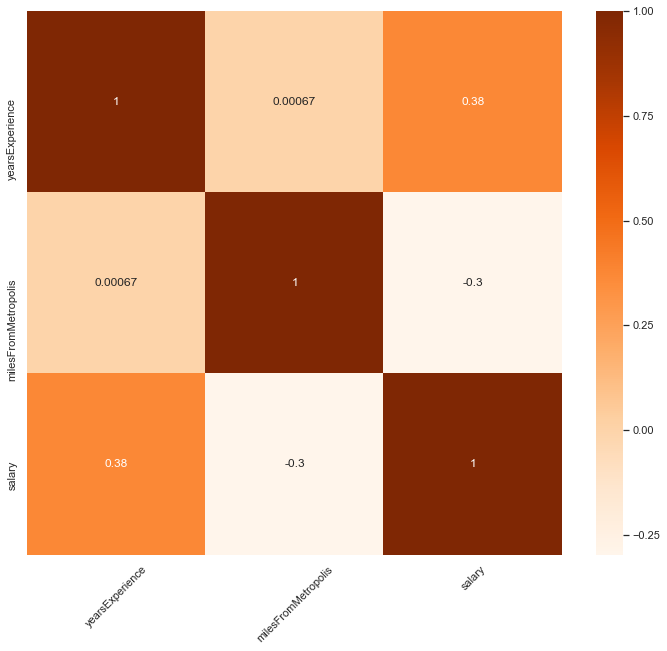

In [150]:
# Graphical Representation of Correlation using HeatMap
fig = plt.figure(figsize=(12,10))
ax = sns.heatmap(salaryPred_Train_data.corr(), cmap = 'Oranges', annot = True)
plt.xticks(rotation=45)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

This correlation HeatMap clearly suggests that salary has a strong relation with jobType followed by major. Also jobType has strong correlation with degree followed by major.

### ---- 5 Establish a baseline ----

In [151]:
#select a reasonable metric (MSE in this case)
#create an extremely simple model and measure its efficacy
#e.g. use "average salary" for each industry as your model and then measure MSE
#during 5-fold cross-validation


### ---- 6 Hypothesize solution ----

In [152]:
#brainstorm 3 models that you think may improve results over the baseline model based
#on your 

Brainstorm 3 models that you think may improve results over the baseline model based on your EDA and explain why they're reasonable solutions here.

Also write down any new features that you think you should try adding to the model based on your EDA, e.g. interaction variables, summary statistics for each group, etc

## Part 3 - DEVELOP

You will cycle through creating features, tuning models, and training/validing models (steps 7-9) until you've reached your efficacy goal

#### Your metric will be MSE and your goal is:
 - <360 for entry-level data science roles
 - <320 for senior data science roles

### ---- 7 Engineer features  ----

In [153]:
#make sure that data is ready for modeling
#create any new features needed to potentially enhance model
#load the data into a Pandas dataframe
def load_dataset():
    trainData_features_df = pd.read_csv("/Users/nikhilgharge93gmail.com/Desktop/Data Science Dream Job/Instructions_and_Notebook/salaryPredictionPortfolio/Data/train_features.csv")
    trainData_target_df = pd.read_csv("/Users/nikhilgharge93gmail.com/Desktop/Data Science Dream Job/Instructions_and_Notebook/salaryPredictionPortfolio/Data/train_salaries.csv")
    testData_features_df = pd.read_csv("/Users/nikhilgharge93gmail.com/Desktop/Data Science Dream Job/Instructions_and_Notebook/salaryPredictionPortfolio/Data/test_features.csv")
    return trainData_features_df, trainData_target_df, testData_features_df    

In [154]:
trainData_features_df, trainData_target_df, testData_features_df = load_dataset()

In [155]:
trainData_features_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [156]:
trainData_target_df.head()

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


In [157]:
testData_features_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44


In [158]:
# Create a final dataset by merging trainData_features_df and trainData_target_df
def merge_Datasets():
    salaryPred_Train_data = pd.merge(trainData_features_df,trainData_target_df,how='inner',on='jobId')
    return salaryPred_Train_data

In [159]:
salaryPred_Train_data = merge_Datasets()
salaryPred_Train_data.head()
salaryPred_Train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
salary                 1000000 non-null int64
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


In [160]:
# Check for duplicates and insiginificant data
def clean_data(): 
    sal_Pred_df = salaryPred_Train_data.drop_duplicates(subset="jobId")
    sal_Pred_df = salaryPred_Train_data[salaryPred_Train_data["salary"] > 0]
    return sal_Pred_df

In [161]:
sal_pred_df = clean_data()
sal_pred_df.head()
sal_pred_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999995 entries, 0 to 999999
Data columns (total 9 columns):
jobId                  999995 non-null object
companyId              999995 non-null object
jobType                999995 non-null object
degree                 999995 non-null object
major                  999995 non-null object
industry               999995 non-null object
yearsExperience        999995 non-null int64
milesFromMetropolis    999995 non-null int64
salary                 999995 non-null int64
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


In [162]:
# identifying the categorical and numerical features
sal_pred_cat_features = ["companyId", "jobType", "degree", "major", "industry"]
sal_pred_num_features = ["yearsExperience", "milesFromMetropolis"]
sal_pred_target = "salary"

In [163]:
# onehotencoding is performed
def encode_features(salPredDF, cat_feat=None, num_feat=None):
    cat_features = pd.get_dummies(salPredDF[cat_feat])
    num_features = salPredDF[num_feat].apply(pd.to_numeric)
    return pd.concat([cat_features,num_features], axis = 1)

In [164]:
sal_pred_features_df = encode_features(sal_pred_df, cat_feat=sal_pred_cat_features, num_feat=sal_pred_num_features)
sal_pred_features_df.head()

,companyId_COMP0,companyId_COMP1,companyId_COMP10,companyId_COMP11,companyId_COMP12,companyId_COMP13,companyId_COMP14,companyId_COMP15,companyId_COMP16,companyId_COMP17,...,major_PHYSICS,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB,yearsExperience,milesFromMetropolis
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,10,83
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,3,73
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,10,38
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,8,17
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,8,16


In [165]:
sal_pred_test_df = encode_features(testData_features_df, cat_feat=sal_pred_cat_features, num_feat=sal_pred_num_features)
sal_pred_test_df.head()

,companyId_COMP0,companyId_COMP1,companyId_COMP10,companyId_COMP11,companyId_COMP12,companyId_COMP13,companyId_COMP14,companyId_COMP15,companyId_COMP16,companyId_COMP17,...,major_PHYSICS,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB,yearsExperience,milesFromMetropolis
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,22,73
1,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,20,47
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,17,9
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,14,96
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,10,44


In [166]:
# Add the target column to the final dataset
def target_dataset():
    # get target_df for further computation
    return sal_pred_df['salary']

In [167]:
sal_pred_target_df = target_dataset()
sal_pred_target_df.head()

0    130
1    101
2    137
3    142
4    163
Name: salary, dtype: int64

### ---- 8 Create models ----

In [270]:
#create and tune the models that you brainstormed during part 2
models = []
mean_mse = {}
cv_std = {}
lin_Reg = LinearRegression()
lin_Reg_std_pca = make_pipeline(StandardScaler(), PCA(), LinearRegression())
random_forest = RandomForestRegressor(n_estimators=60, n_jobs=-1, max_depth=25, min_samples_split=60, \
                               max_features=30, verbose=5)
grad_Boost_Reg = GradientBoostingRegressor(n_estimators=40, max_depth=5, loss='ls', verbose=5)

# Appending each models
models = [lin_Reg, lin_Reg_std_pca, random_forest, grad_Boost_Reg]

### ---- 9 Test models ----

In [271]:
#do 5-fold cross validation on models and measure MSE
def train_model(model, feature_df, target_df, mean_mse, cv_std):
    MSE = -1.00*cross_val_score(model, feature_df, target_df, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
    mean_mse[model] = np.mean(MSE)
    cv_std[model] = np.std(MSE)

In [272]:
for i in range(len(models)):
    train_model(models[i], sal_pred_features_df, sal_pred_target_df, mean_mse, cv_std)
                   

In [273]:
for model in models:
    print('\nModel:\n', model)
    print('Average MSE:\n', mean_mse[model])
    print('Standard deviation during CV:\n', cv_std[model])


Model:
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
Average MSE:
 384.4440579495867
Standard deviation during CV:
 1.7657232999801469

Model:
 Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])
Average MSE:
 384.44651107554216
Standard deviation during CV:
 1.7668108071404287

Model:
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features=30, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=60, min_weight_fraction_leaf=0.0,
           n_estimators=60, n_jobs=-1, oob_score=False, random_state=None,
           verbose=5, war

### ---- 10 Select best model  ----

In [274]:
#select the model with the lowest error as your "production" model
model = min(mean_mse, key=mean_mse.get)
print("Model with lowest MSE")
print(model)

Model with lowest MSE
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features=30, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=60, min_weight_fraction_leaf=0.0,
           n_estimators=60, n_jobs=-1, oob_score=False, random_state=None,
           verbose=5, warm_start=False)


## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [275]:
#write script that trains model on entire training set, saves model to disk,
#and scores the "test" dataset

# Fitting the model to trainset
model.fit(sal_pred_features_df, sal_pred_target_df)

# Create predictions on test data
sal_predictions = model.predict(sal_pred_test_df)
sal_predictions.head()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 60building tree 2 of 60
building tree 3 of 60
building tree 4 of 60

building tree 5 of 60
building tree 6 of 60
building tree 7 of 60
building tree 8 of 60
building tree 9 of 60building tree 10 of 60
building tree 11 of 60
building tree 12 of 60

building tree 13 of 60
building tree 14 of 60
building tree 15 of 60
building tree 16 of 60
building tree 17 of 60
building tree 18 of 60
building tree 19 of 60
building tree 20 of 60
building tree 21 of 60
building tree 22 of 60
building tree 23 of 60
building tree 24 of 60
building tree 25 of 60
building tree 26 of 60
building tree 27 of 60
building tree 28 of 60
building tree 29 of 60
building tree 30 of 60
building tree 31 of 60
building tree 32 of 60
building tree 33 of 60building tree 34 of 60building tree 35 of 60


building tree 36 of 60
building tree 37 of 60
building tree 38 of 60
building tree 39 of 60
building tree 40 of 60
building tree 41 of 60
building tree 42 of 60
building tree 43 of 60
building tree 44 of 

[Parallel(n_jobs=-1)]: Done  50 out of  60 | elapsed:  2.0min remaining:   23.5s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.0min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  50 out of  60 | elapsed:    4.5s remaining:    0.9s
[Parallel(n_jobs=12)]: Done  60 out of  60 | elapsed:    4.6s finished


array([113.80217876,  93.28918327, 179.68118703, ...,  56.33465077,
       158.13256689, 108.62408029])

### ---- 12 Deploy solution ----

In [278]:
#save your prediction to a csv file or optionally save them as a table in a SQL database
#additionally, you want to save a visualization and summary of your prediction and feature importances
#these visualizations and summaries will be extremely useful to business stakeholders
import pickle

In [279]:
# given a name for the file to store the model
filename = "Finalized_model.pkl"

In [280]:
# save the model to a file
with open(filename, 'wb') as file:
    pickle.dump(model, file)

In [281]:
# load the model from file
with open(filename, 'rb') as file:
    loaded_model = pickle.load(file)


In [302]:
# Create a new Dataframe predictions with columns JobId and Predictions
predictions_df = pd.concat([sal_pred_test_df,pd.DataFrame(sal_predictions,columns=['expected_salary'])],axis=1)
predictions_df.head()

,companyId_COMP0,companyId_COMP1,companyId_COMP10,companyId_COMP11,companyId_COMP12,companyId_COMP13,companyId_COMP14,companyId_COMP15,companyId_COMP16,companyId_COMP17,...,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB,yearsExperience,milesFromMetropolis,expected_salary
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,22,73,113.802179
1,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,20,47,93.289183
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,17,9,179.681187
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,14,96,104.911713
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,10,44,112.655216


In [ ]:
# save the file to csv
predictions_df.to_csv('/Users/nikhilgharge93gmail.com/Desktop/prediction_df.csv')

### Feature Importance 

In [285]:
# Create an dataframe consisting of important features.
importances = model.feature_importances_
feature_importances = pd.DataFrame({'feature':sal_pred_features_df.columns, 'importance':importances})
feature_importances.sort_values(by='importance',ascending=False,inplace=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 25 Text xticklabel objects>)

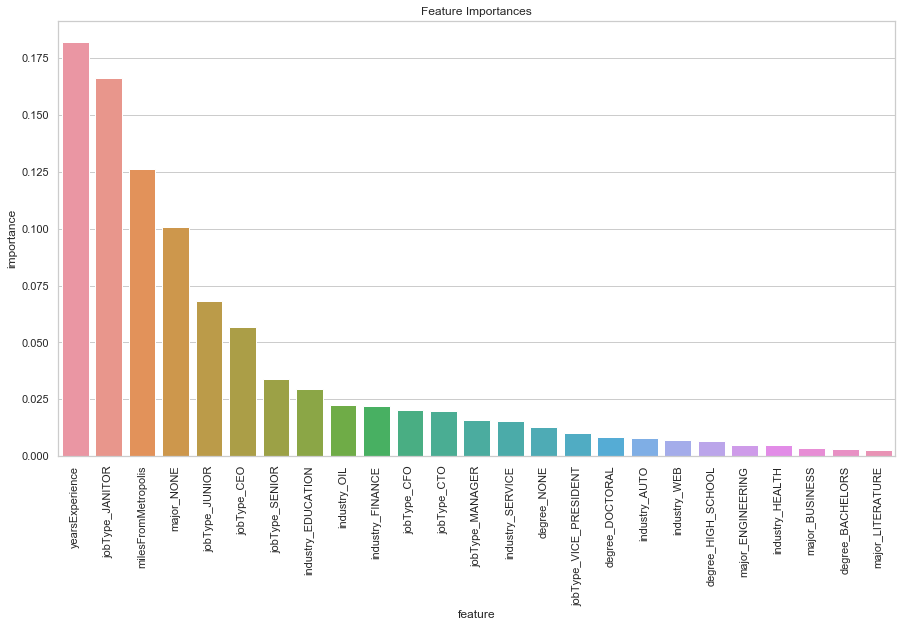

In [297]:
#Visualization
f, ax = plt.subplots(figsize=(15,8))
Feature_Importances = sns.barplot(x='feature',y='importance',data=feature_importances[0:25])
plt.title('Feature Importances')
plt.xticks(rotation=90)